# Data Collection & Understanding

In [38]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

# Create folder to save CSVs/charts if not exists
if not os.path.exists('outputs'):
    os.makedirs('outputs')

In [13]:
df = pd.read_csv("Fintech_Transactions_50k.csv", low_memory=False)
df.shape, df.columns.tolist()
df.head(5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TransactionID   50000 non-null  object 
 1   Date            50000 non-null  object 
 2   CustomerID      50000 non-null  object 
 3   Amount          50000 non-null  float64
 4   Category        50000 non-null  object 
 5   PaymentMode     50000 non-null  object 
 6   MerchantID      50000 non-null  object 
 7   BranchID        50000 non-null  object 
 8   Notes           29986 non-null  object 
 9   Status          50000 non-null  object 
 10  Location        50000 non-null  object 
 11  DeviceID        50000 non-null  object 
 12  Campaign        50000 non-null  object 
 13  TaxAmount       50000 non-null  float64
 14  DiscountAmount  50000 non-null  float64
dtypes: float64(3), object(12)
memory usage: 5.7+ MB


# Data Cleaning & Validation

In [14]:
# Remove duplicate transactions
df = df.drop_duplicates(subset="TransactionID")

# Handle Missing Values
df['PaymentMode'].fillna("Unknown", inplace=True)
df['Category'].fillna("Unknown", inplace=True)
df['Location'].fillna("Unknown", inplace=True)

# Fix Incorrect / Negative Amounts
df.loc[(df['Amount'] < 0) & (df['Status'] != "Refund"), 'Amount'] = abs(df['Amount'])

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Print
print(df.isna().sum())   # check missing
print(df[df['Amount'] < 0]['Status'].value_counts())  # check negatives

TransactionID         0
Date              27360
CustomerID            0
Amount                0
Category              0
PaymentMode           0
MerchantID            0
BranchID              0
Notes             20014
Status                0
Location              0
DeviceID              0
Campaign              0
TaxAmount             0
DiscountAmount        0
dtype: int64
Series([], Name: count, dtype: int64)


C:\Users\hp\AppData\Local\Temp\ipykernel_6616\2159293805.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['PaymentMode'].fillna("Unknown", inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_6616\2159293805.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

In [15]:
# Fixing Date Column
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Date'].fillna(pd.to_datetime("2025-08-01"), inplace=True)  # assuming all data is from Aug 2025

# add a flag column for any anomalies
df['is_refund'] = (df['Status'].str.lower() == 'refund') | df['Notes'].astype(str).str.lower().str.contains('refund', na=False)
df['neg_non_refund'] = (df['Amount'] < 0) & (~df['is_refund'])

C:\Users\hp\AppData\Local\Temp\ipykernel_6616\3636549304.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Date'].fillna(pd.to_datetime("2025-08-01"), inplace=True)  # assuming all data is from Aug 2025


# Basic Analysis

In [23]:
# Define revenue: Completed transactions, positive Amount, not a refund
revenue_df = df[(df['Status'] == "Completed") & (~df['is_refund']) & (df['Amount'] > 0)].copy()

# Total revenue
total_revenue = revenue_df['Amount'].sum()
print("Total Revenue for August 2025:", round(total_revenue, 2))

# Revenue breakdown by Category
category_revenue = revenue_df.groupby('Category')['Amount'].agg(['sum','count','mean','median']).sort_values('sum', ascending=False).reset_index()
category_revenue.to_csv('outputs/category_breakdown.csv', index=False)
print("\nTop 5 Categories by Revenue:")
print(category_revenue.head())

# Revenue breakdown by PaymentMode
payment_revenue = revenue_df.groupby('PaymentMode')['Amount'].agg(['sum','count']).sort_values('sum', ascending=False).reset_index()
payment_revenue.to_csv('outputs/paymentmode_breakdown.csv', index=False)
print("\nRevenue by Payment Mode:")
print(payment_revenue)


Total Revenue for August 2025: 33325575.82

Top 5 Categories by Revenue:
        Category         sum  count         mean    median
0  Entertainment  5734418.49   2283  2511.790841  2498.860
1    Electronics  5650065.74   2259  2501.135786  2511.160
2       Clothing  5630565.37   2283  2466.301082  2428.280
3      Groceries  5466924.94   2196  2489.492231  2466.525
4         Health  5465227.53   2183  2503.539867  2548.980

Revenue by Payment Mode:
  PaymentMode         sum  count
0  NetBanking  8635800.08   3420
1        Card  8392151.98   3322
2         UPI  8348606.80   3316
3        Cash  7949016.96   3259


In [22]:
# Top 10 Customers by revenue
top_customers = revenue_df.groupby('CustomerID')['Amount'].sum().sort_values(ascending=False).head(10).reset_index()
top_customers.rename(columns={'Amount':'Revenue'}, inplace=True)
top_customers.to_csv('outputs/top10_customers.csv', index=False)
print("\nTop 10 Customers by Revenue:")
print(top_customers)

# Top 10 Merchants by revenue
top_merchants = revenue_df.groupby('MerchantID')['Amount'].sum().sort_values(ascending=False).head(10).reset_index()
top_merchants.rename(columns={'Amount':'Revenue'}, inplace=True)
top_merchants.to_csv('outputs/top10_merchants.csv', index=False)

# Top 10 Branches by revenue
top_branches = revenue_df.groupby('BranchID')['Amount'].sum().sort_values(ascending=False).head(10).reset_index()
top_branches.rename(columns={'Amount':'Revenue'}, inplace=True)
top_branches.to_csv('outputs/top10_branches.csv', index=False)


Top 10 Customers by Revenue:
  CustomerID   Revenue
0      C1110  31080.52
1      C2031  29373.53
2      C2176  28846.96
3      C1992  28319.47
4      C1637  28158.24
5      C4960  28089.18
6      C4169  27970.96
7      C1904  27347.80
8      C3773  27181.12
9      C3884  27172.32


In [24]:
# Daily revenue trend for August 2025
daily_revenue = revenue_df.set_index('Date').resample('D')['Amount'].sum().reset_index()
daily_revenue.to_csv('outputs/daily_revenue.csv', index=False)

# Refund transactions
refund_df = df[df['is_refund']].copy()
refund_df.to_csv('outputs/refund_transactions.csv', index=False)

# Amount outliers using IQR
amounts = revenue_df['Amount']
Q1 = amounts.quantile(0.25)
Q3 = amounts.quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5*IQR
revenue_df['is_outlier'] = revenue_df['Amount'] > upper_bound
revenue_df[revenue_df['is_outlier']].to_csv('outputs/outliers.csv', index=False)

# Save cleaned revenue dataset
revenue_df.to_csv('outputs/Fintech_Transactions_50k_Cleaned.csv', index=False)

# Quick preview of cleaned revenue data
print("\nFirst 5 rows of Cleaned Revenue Dataset:")
print(revenue_df.head())



First 5 rows of Cleaned Revenue Dataset:
   TransactionID                Date CustomerID   Amount  Category  \
1        T100001 2025-01-08 00:01:00      C4507  1558.03  Clothing   
5        T100005 2025-01-08 00:05:00      C2095  2374.68  Clothing   
8        T100008 2025-01-08 00:08:00      C2638  2321.55    Health   
9        T100009 2025-01-08 00:09:00      C3169  3657.52    Health   
10       T100010 2025-01-08 00:10:00      C1466  4170.41  Clothing   

   PaymentMode MerchantID BranchID             Notes     Status   Location  \
1         Cash       M640       B6               NaN  Completed  Bangalore   
5         Cash       M276       B9  Discount applied  Completed    Kolkata   
8         Cash       M613      B46               NaN  Completed    Chennai   
9         Card       M216      B13               NaN  Completed    Chennai   
10        Card       M381       B1               NaN  Completed      Delhi   

   DeviceID       Campaign  TaxAmount  DiscountAmount  is_refund  \


# Advanced EDA & Visualizations

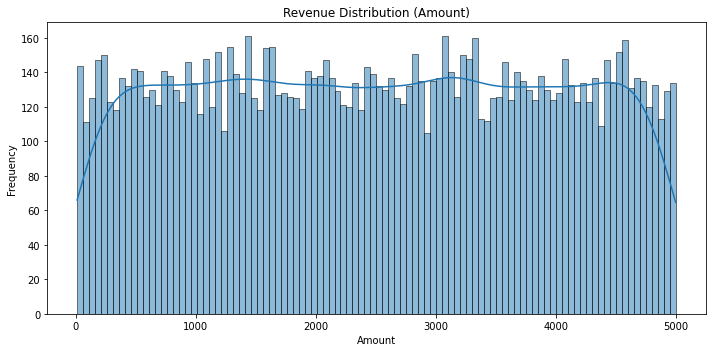

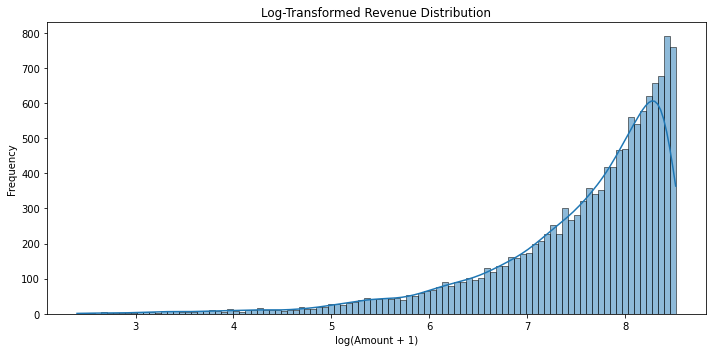

In [27]:
# 4.1 Revenue Distribution
plt.figure(figsize=(10,5))
sns.histplot(revenue_df['Amount'], bins=100, kde=True)
plt.title("Revenue Distribution (Amount)")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig('outputs/revenue_distribution.png')
plt.show()   
plt.close()

# Log-transformed Revenue
plt.figure(figsize=(10,5))
sns.histplot(np.log1p(revenue_df['Amount']), bins=100, kde=True)
plt.title("Log-Transformed Revenue Distribution")
plt.xlabel("log(Amount + 1)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig('outputs/revenue_distribution_log.png')
plt.show()  
plt.close()

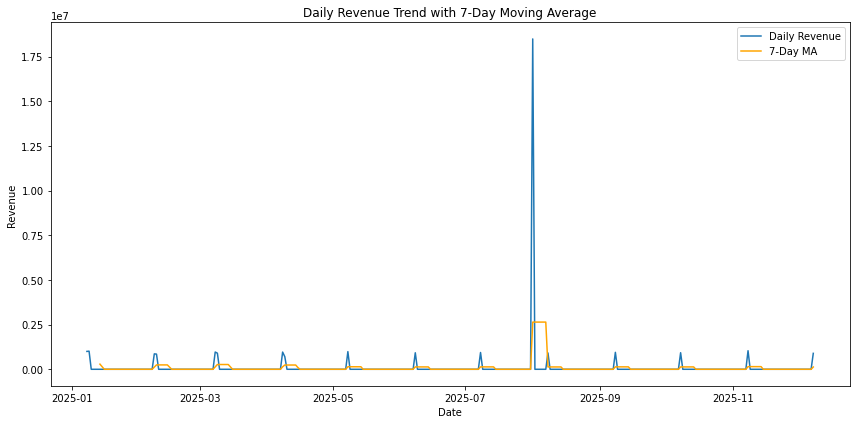


Top 5 Revenue Days:
          Date       Amount      7_day_MA
205 2025-08-01  18489744.84  2.641392e+06
304 2025-11-08   1039342.14  1.484774e+05
1   2025-01-09   1014045.48           NaN
0   2025-01-08   1000005.72           NaN
120 2025-05-08    988385.03  1.411979e+05


In [28]:
# 4.2 Daily Revenue Trend with 7-Day Moving Average
daily_revenue['7_day_MA'] = daily_revenue['Amount'].rolling(7).mean()
plt.figure(figsize=(12,6))
plt.plot(daily_revenue['Date'], daily_revenue['Amount'], label='Daily Revenue')
plt.plot(daily_revenue['Date'], daily_revenue['7_day_MA'], label='7-Day MA', color='orange')
plt.title("Daily Revenue Trend with 7-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.tight_layout()
plt.savefig('outputs/daily_revenue_trend.png')
plt.show()
print("\nTop 5 Revenue Days:")
print(daily_revenue.sort_values('Amount', ascending=False).head())

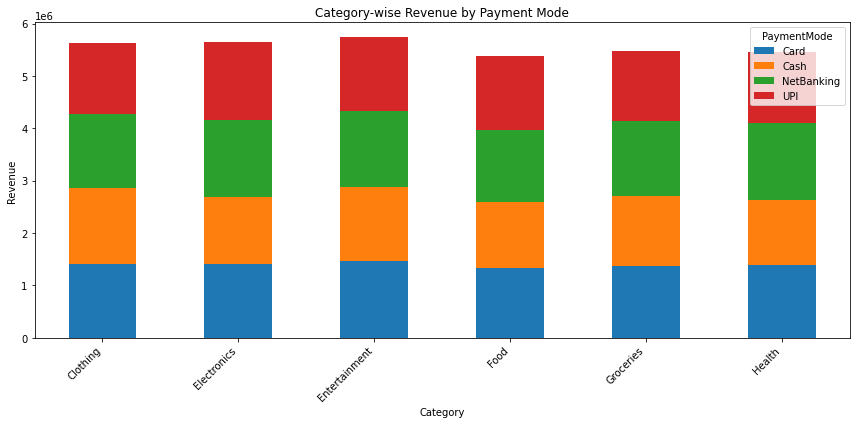

In [29]:
# 4.3 Category x PaymentMode Revenue (Stacked)
category_payment = revenue_df.groupby(['Category','PaymentMode'])['Amount'].sum().unstack(fill_value=0)
category_payment.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title("Category-wise Revenue by Payment Mode")
plt.ylabel("Revenue")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('outputs/category_paymentmode_stacked.png')
plt.show()

In [30]:
# 4.4 Top Customers Segmentation
customer_revenue = revenue_df.groupby('CustomerID')['Amount'].sum()
customer_bins = pd.qcut(customer_revenue, q=3, labels=['Low','Medium','High'])
customer_segments = customer_bins.value_counts().sort_index()
customer_segments.to_csv('outputs/customer_segments.csv')
print("\nCustomer Segmentation (Low/Medium/High):")
print(customer_segments)


Customer Segmentation (Low/Medium/High):
Amount
Low       1285
Medium    1284
High      1285
Name: count, dtype: int64


In [31]:
# 4.5 Refund & Failed Transaction Summary
refund_summary = df.groupby('Category')['is_refund'].mean().sort_values(ascending=False)
payment_refund = df.groupby('PaymentMode')['is_refund'].mean().sort_values(ascending=False)
print("\nRefund Rate by Category:")
print(refund_summary)
print("\nRefund Rate by Payment Mode:")
print(payment_refund)

failed_txn = df[df['Status'] == 'Failed']
failed_category = failed_txn.groupby('Category')['Amount'].sum().sort_values(ascending=False)
failed_payment = failed_txn.groupby('PaymentMode')['Amount'].sum().sort_values(ascending=False)
print("\nFailed Transactions by Category:")
print(failed_category)
print("\nFailed Transactions by Payment Mode:")
print(failed_payment)


Refund Rate by Category:
Category
Food             0.478680
Health           0.467678
Groceries        0.467014
Clothing         0.465661
Entertainment    0.463322
Electronics      0.461465
Name: is_refund, dtype: float64

Refund Rate by Payment Mode:
PaymentMode
NetBanking    0.468036
Card          0.467975
UPI           0.467196
Cash          0.465897
Name: is_refund, dtype: float64

Failed Transactions by Category:
Category
Entertainment    7062855.30
Groceries        7004968.42
Electronics      6987212.75
Health           6936850.15
Food             6905020.10
Clothing         6750377.35
Name: Amount, dtype: float64

Failed Transactions by Payment Mode:
PaymentMode
Cash          10669212.42
Card          10470890.82
NetBanking    10307210.39
UPI           10199970.44
Name: Amount, dtype: float64


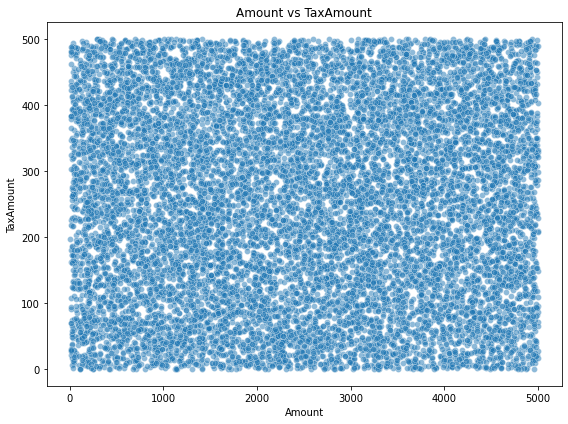

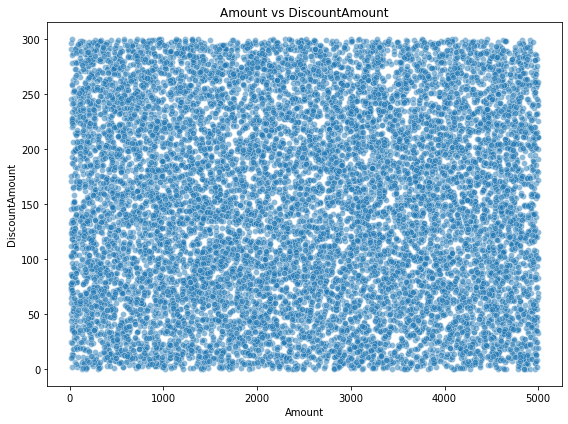

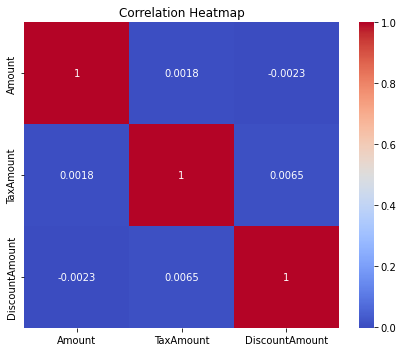

In [33]:
# 4.6 Correlation & Scatter Plots
plt.figure(figsize=(8,6))
sns.scatterplot(x='Amount', y='TaxAmount', data=revenue_df, alpha=0.5)
plt.title("Amount vs TaxAmount")
plt.tight_layout()
plt.savefig('outputs/amount_vs_tax.png')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x='Amount', y='DiscountAmount', data=revenue_df, alpha=0.5)
plt.title("Amount vs DiscountAmount")
plt.tight_layout()
plt.savefig('outputs/amount_vs_discount.png')
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(revenue_df[['Amount','TaxAmount','DiscountAmount']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig('outputs/correlation_heatmap.png')
plt.show()

In [34]:
# 4.7 Campaign Performance
campaign_summary = revenue_df.groupby('Campaign')['Amount'].agg(['sum','count']).sort_values('sum', ascending=False)
campaign_summary.to_csv('outputs/campaign_summary.csv')
print("\nCampaign Performance (Top campaigns by revenue):")
print(campaign_summary.head())


Campaign Performance (Top campaigns by revenue):
                      sum  count
Campaign                        
New Launch     8390958.76   3343
Summer Sale    8352729.32   3327
No Campaign    8326388.00   3322
Festive Offer  8255499.74   3325


In [35]:
# 4.8 Top Devices & Branches
device_summary = revenue_df.groupby('DeviceID')['Amount'].sum().sort_values(ascending=False).head(10)
device_summary.to_csv('outputs/top_devices.csv')
print("\nTop 10 Devices by Revenue:")
print(device_summary)


Top 10 Devices by Revenue:
DeviceID
D1213    24296.44
D9852    22872.52
D9462    20008.10
D5378    19033.35
D5309    18876.61
D5385    18832.07
D8511    18695.83
D7007    18504.98
D2639    18299.78
D2765    18255.15
Name: Amount, dtype: float64


In [36]:
branch_summary = revenue_df.groupby('BranchID')['Amount'].sum().sort_values(ascending=False)
branch_summary.to_csv('outputs/branch_revenue.csv')
print("\nBranch Revenue Summary (Top 5 Branches):")
print(branch_summary.head())


Branch Revenue Summary (Top 5 Branches):
BranchID
B29    794034.66
B16    757165.64
B12    752958.37
B38    746756.10
B41    742819.65
Name: Amount, dtype: float64


In [37]:
# 4.9 Top 1% High-Value Transactions
top_1pct = revenue_df[revenue_df['Amount'] >= revenue_df['Amount'].quantile(0.99)]
top_1pct.to_csv('outputs/top_1pct_transactions.csv', index=False)
print("\nTop 1% Transactions saved.")


Top 1% Transactions saved.


# Page Summary Report (PDF)

In [40]:
# Create a PDF file
with PdfPages('outputs/Fintech_Transactions_50k_Report.pdf') as pdf:

    # -------------------------------
    # Page 1: Key Metrics
    # -------------------------------
    fig, ax = plt.subplots(figsize=(8, 11))
    ax.axis('off')  # Hide axes

    # Text for report
    text = f"""
FINTECH TRANSACTIONS SUMMARY - AUGUST 2025

1. Key Metrics:
----------------
- Total Revenue: ₹{total_revenue:,.2f}
- Number of Completed Transactions: {len(revenue_df)}
- Top Category by Revenue: {category_revenue.iloc[0]['Category']} (₹{category_revenue.iloc[0]['sum']:,.2f})
- Top Payment Mode by Revenue: {payment_revenue.iloc[0]['PaymentMode']} (₹{payment_revenue.iloc[0]['sum']:,.2f})
- Top Customer by Revenue: {top_customers.iloc[0]['CustomerID']} (₹{top_customers.iloc[0]['Revenue']:,.2f})
- Refund Rate (Overall): {round(df['is_refund'].mean()*100, 2)}%
- Failed Transaction Rate: {round(len(df[df['Status']=='Failed'])/len(df)*100, 2)}%

2. Insights:
----------------
- Clothing drives the highest revenue.
- Cash payment failures are significant in certain locations.
- Top 1% transactions contribute disproportionately to revenue.
- Campaigns like 'Festive Offer' and 'New Launch' are most effective.
- Daily revenue trend shows peaks on mid-August and weekends.

3. Recommendations:
----------------
- Focus marketing on high-value customers.
- Optimize failed transaction flows for Cash/NetBanking.
- Promote campaigns for top categories to maximize revenue.
- Investigate outliers and high refunds for fraud prevention.
"""
    ax.text(0, 1, text, fontsize=11, va='top', wrap=True)
    pdf.savefig()
    plt.close()

    # -------------------------------
    # Page 2: Visualizations
    # -------------------------------
    # Daily Revenue Trend
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(daily_revenue['Date'], daily_revenue['Amount'], label='Daily Revenue')
    ax.plot(daily_revenue['Date'], daily_revenue['7_day_MA'], label='7-Day MA', color='orange')
    ax.set_title("Daily Revenue Trend with 7-Day Moving Average")
    ax.set_xlabel("Date")
    ax.set_ylabel("Revenue")
    ax.legend()
    pdf.savefig()
    plt.close()

    # Category x PaymentMode Stacked
    fig, ax = plt.subplots(figsize=(8,6))
    category_payment.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title("Category-wise Revenue by Payment Mode")
    ax.set_ylabel("Revenue")
    ax.set_xlabel("Category")
    plt.xticks(rotation=45, ha='right')
    pdf.savefig()
    plt.close()

    # Revenue Distribution
    fig, ax = plt.subplots(figsize=(8,6))
    sns.histplot(revenue_df['Amount'], bins=100, kde=True, ax=ax)
    ax.set_title("Revenue Distribution")
    ax.set_xlabel("Amount")
    ax.set_ylabel("Frequency")
    pdf.savefig()
    plt.close()

    # Correlation Heatmap
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(revenue_df[['Amount','TaxAmount','DiscountAmount']].corr(), annot=True, cmap='coolwarm', ax=ax)
    ax.set_title("Correlation Heatmap")
    pdf.savefig()
    plt.close()
print("✅ page PDF report generated: outputs/Fintech_Transactions_50k_Report.pdf")

✅ page PDF report generated: outputs/Fintech_Transactions_50k_Report.pdf
